In [55]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
        pass

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # 目标图像（标签），独热编码
        label = self.data_df.iloc[index, 0]
        target = torch.zeros((10))
        target[label] = 1.0

        # 图像数据，取值范围是0~255，标准化为0~1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

        # 返回标签、图像数据张量以及目标张量
        return label, image_values, target

    def plot_image(self, index):
        arr = self.data_df.iloc[index,1:].values.reshape(28, 28)
        plt.title("label = " + str(self.data_df.iloc[index, 0]))
        plt.imshow(arr, interpolation='none', cmap='Blues')
    pass

In [57]:
mnist_dataset = MnistDataset('../data/mnist_train.csv')

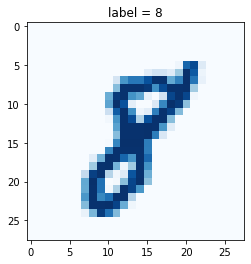

In [58]:
mnist_dataset.plot_image(17)

In [59]:
def generate_random_image(size):
    random_data = torch.rand(size) # 均匀分布
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size) # 标准正态分布
    return random_data

In [60]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),
            
            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.BCELoss()

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)

        loss = self.loss_function(outputs, targets)
        
        self.counter += 1
        if self.counter%10 == 0:
            self.progress.append(loss.item())
            pass
        if self.counter%10000 == 0:
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    pass

In [61]:
%%time

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # 真实数据
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # 虚假数据
    D.train(generate_random_image(784), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
Wall time: 1min 59s


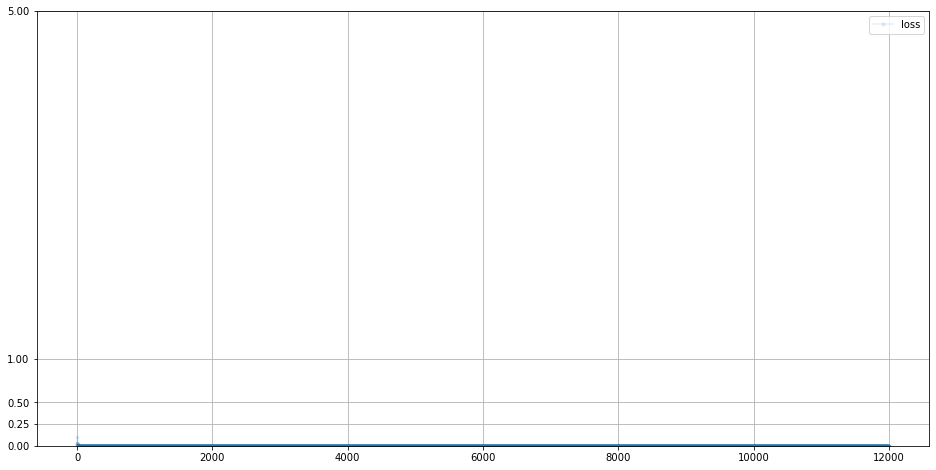

In [62]:
D.plot_progress()

### <center>鉴别能力判断</center>

In [63]:
for i in range(4):
  # 60000条数据中随机的一条真实数据
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward( image_data_tensor ).item())
  pass

for i in range(4):
  # 随机噪声
  print( D.forward(generate_random_image(784)).item() )
  pass

1.0
1.0
1.0
1.0
1.0160792346392e-11
1.0841552482154793e-11
9.014436766485723e-12
9.42537888015682e-12


In [64]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),
            
            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        return self.model(inputs)

        pass

    def train(self, D, inputs, targets):
        # 计算网络输出
        g_output = self.forward(inputs)

        # 输入鉴别器
        d_output = D.forward(g_output)

        # 计算损失值
        loss = D.loss_function(d_output, targets)

        # 每训练10次增加计数器
        self.counter += 1
        if self.counter%10 == 0:
            self.progress.append(loss.item())
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    pass


### <center>测试生成器</center>

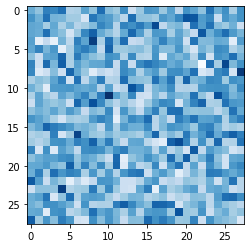

In [65]:
G = Generator()

output = G.forward(generate_random_seed(100))

img = output.detach().numpy().reshape(28, 28)

plt.imshow(img, interpolation='none', cmap='Blues')

### <center>训练GAN</center>

In [66]:
%%time

D = Discriminator()
G = Generator()

epochs = 4

for epoch in range(epochs):
    print("epoch = ", epoch + 1)

    for label, image_data_tensor, target_tensor in mnist_dataset:
        # 用真实数据训练鉴别器
        D.train(image_data_tensor, torch.FloatTensor([1.0]))

        # 用虚假数据训练鉴别器
        D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))

        # 训练生成器
        G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

        pass
    
    pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
Wall time: 14min 39s


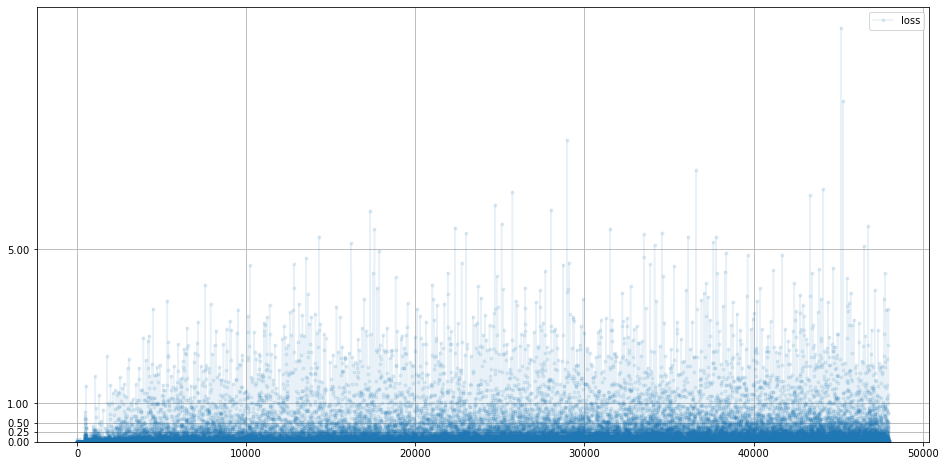

In [67]:
D.plot_progress()

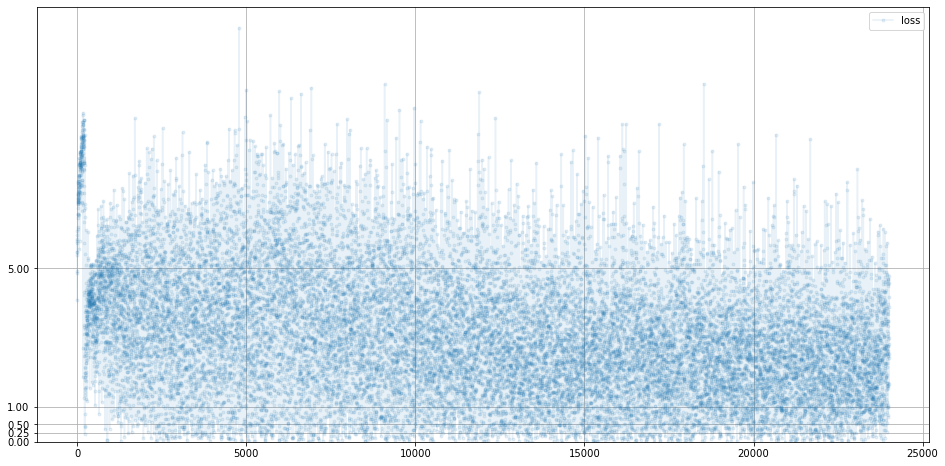

In [68]:
G.plot_progress()

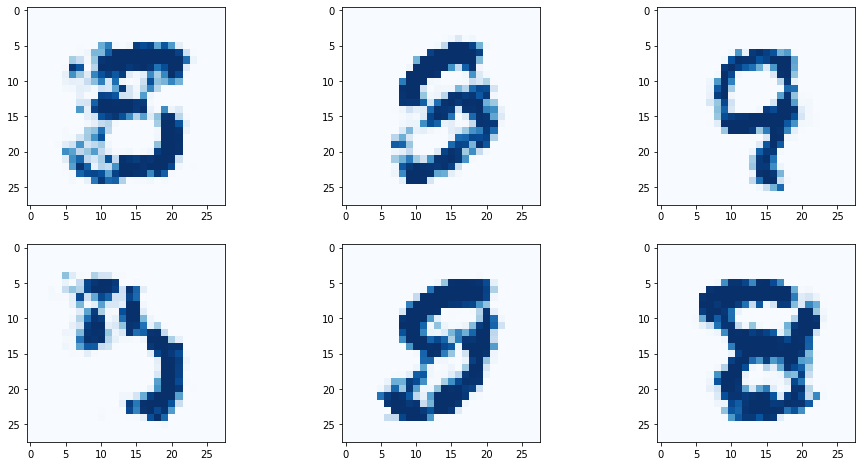

In [69]:
f, axarr = plt.subplots(2,3, figsize=(16, 8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28, 28)
        axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass